## 1. Reading File

In [155]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [132]:
#read in file
df = pd.read_csv("../data/cleaned.csv")
df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Children,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,residence_type_Rural,residence_type_Urban,smoking_status_Formerly smoked,smoking_status_Never smoked,smoking_status_Smokes,smoking_status_Unknown
0,0,67.0,0,1,1,228.69,36.60,1,0,0,0,1,0,0,1,1,0,0,0
1,1,61.0,0,0,1,202.21,28.89,1,0,0,0,0,1,1,0,0,1,0,0
2,0,80.0,0,1,1,105.92,32.50,1,0,0,0,1,0,1,0,0,1,0,0
3,1,49.0,0,0,1,171.23,34.40,1,0,0,0,1,0,0,1,0,0,1,0
4,1,79.0,1,0,1,174.12,24.00,1,0,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,1,13.0,0,0,0,103.08,18.60,0,1,0,0,0,0,1,0,0,0,0,1
4944,1,81.0,0,0,1,125.20,40.00,0,0,0,0,0,1,0,1,0,1,0,0
4945,1,35.0,0,0,1,82.99,30.60,0,0,0,0,0,1,1,0,0,1,0,0
4946,0,51.0,0,0,1,166.29,25.60,0,0,0,0,1,0,1,0,1,0,0,0


## 2. Setting up X and Y values to Evaluate

In [ ]:
#assign x and y and scramble data to seperate datasets
x = df.drop('stroke', axis = 1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [134]:
#using SMOTE to oversample data in training
scaler = StandardScaler(with_mean = False)
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
smote = SMOTE(random_state = 42)
X_res, y_res = smote.fit_resample(X_train_s, y_train)

In [135]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

stroke
0    3759
1     199
Name: count, dtype: int64
stroke
0    3759
1    3759
Name: count, dtype: int64


### 3. Models

In [136]:
def perform_model(model : str, X_train, y_train, x, y):
    #identify chosen model and instantiating model object
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 2000, class_weight = 'balanced', random_state = 2)

    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 2)

    elif model == "SVM":
        mod = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = 2)

    elif model == "XGB":
        mod = XGBClassifier(objective = 'multi:softmax', num_class = 2, random_state = 2)
        X_train.columns = X_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors = 5)


    #trains data
    mod.fit(X_train, y_train)

    #create a prediction for model
    prediction = mod.predict(x)

    conf_matrix = confusion_matrix(y, prediction)
    class_report = classification_report(y, prediction, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, prediction)
    fl_weighted = f1_score(y, prediction, average = 'weighted')
    f1_macro = f1_score(y, prediction, average = 'macro')

    #print results
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1 Weighted: {fl_weighted}')
    print(f'F1 Macro: {f1_macro}')
    print(conf_matrix)

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    # Add labels
    class_labels = ["No Stroke", "Stroke"]
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))

    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()

## 4. Model Performance Checks

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       940
           1       0.14      0.84      0.25        50

    accuracy                           0.74       990
   macro avg       0.57      0.79      0.54       990
weighted avg       0.95      0.74      0.81       990

Balanced Accuracy: 0.7870212765957447
F1 Weighted: 0.8123455491876546
F1 Macro: 0.5440524387892809
[[690 250]
 [  8  42]]


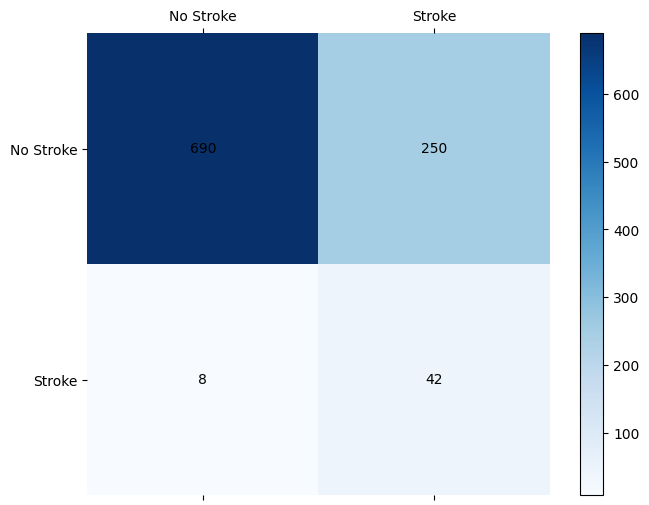

In [137]:
perform_model("Logistic", X_res, y_res, X_test_s, y_test)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       940
           1       0.11      0.14      0.12        50

    accuracy                           0.90       990
   macro avg       0.53      0.54      0.53       990
weighted avg       0.91      0.90      0.90       990

Balanced Accuracy: 0.5396808510638298
F1 Weighted: 0.9048133504048211
F1 Macro: 0.5346082247419192
[[883  57]
 [ 43   7]]


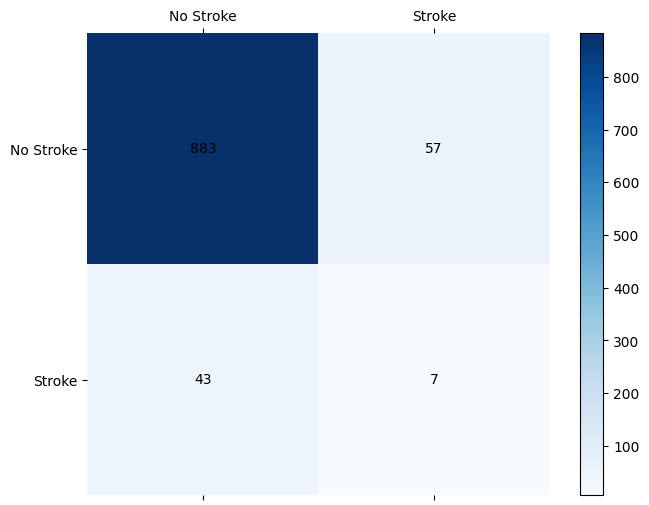

In [138]:
perform_model("RF", X_res, y_res, X_test_s, y_test)

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       940
           1       0.14      0.68      0.23        50

    accuracy                           0.77       990
   macro avg       0.56      0.73      0.55       990
weighted avg       0.94      0.77      0.84       990

Balanced Accuracy: 0.7293617021276596
F1 Weighted: 0.8352570698217648
F1 Macro: 0.5500876452639096
[[732 208]
 [ 16  34]]


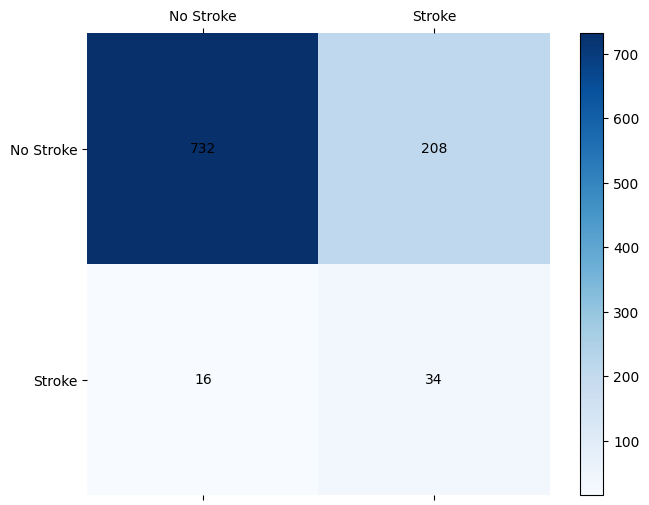

In [139]:
perform_model("SVM", X_res, y_res, X_test_s, y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       940
           1       0.40      0.12      0.18        50

    accuracy                           0.95       990
   macro avg       0.68      0.56      0.58       990
weighted avg       0.93      0.95      0.93       990

Balanced Accuracy: 0.5552127659574468
F1 Weighted: 0.9325405085196209
F1 Macro: 0.5784695722032537
[[931   9]
 [ 44   6]]


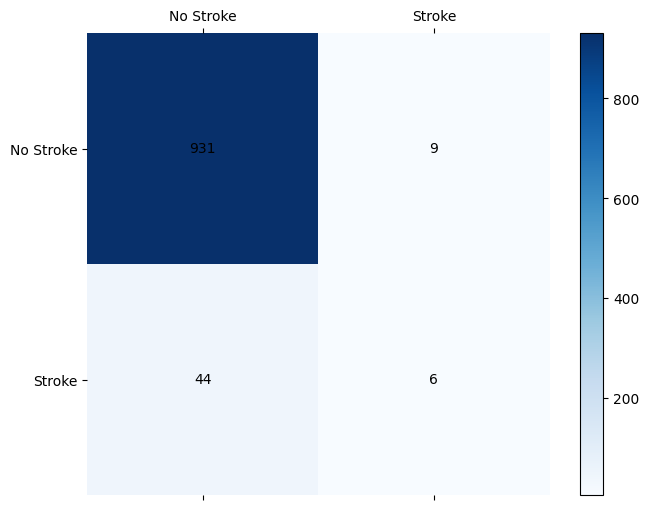

In [140]:
perform_model("XGB", X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       940
           1       0.00      0.00      0.00        50

    accuracy                           0.95       990
   macro avg       0.47      0.50      0.49       990
weighted avg       0.90      0.95      0.92       990

Balanced Accuracy: 0.5
F1 Weighted: 0.9248966347411943
F1 Macro: 0.48704663212435234
[[940   0]
 [ 50   0]]


c:\Users\cwang\OneDrive\Pictures\Documents\PROJECTS FOLDER\stroke-predictions\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


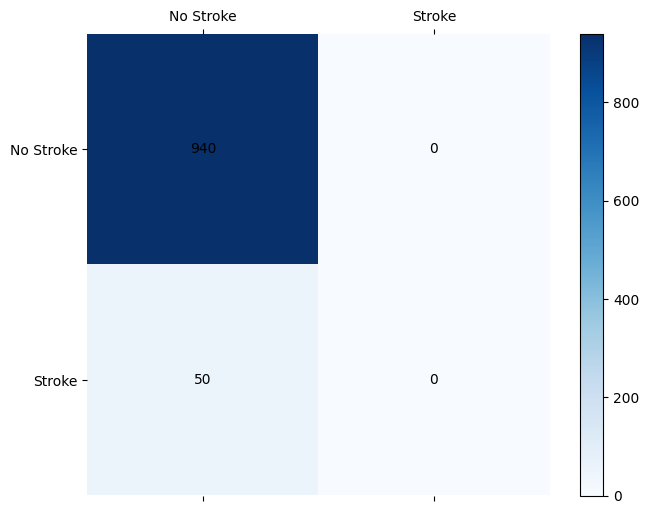

In [141]:
perform_model("KNN", X_train, y_train, X_test_s, y_test)

After looking at these results, Logistic Regression and SVM seem to be outputting the most balanced results. To decide which is better, I will tune both of them and compare their highest scores.

## 5. Hyperparameter Tuning

In [ ]:
#establish parameters for svm
svm_param_grid = {
    "C":     [0.01, 0.1, 0.3, 1, 3, 10, 30, 100],
    "gamma": [0.01, 0.03, 0.1, 0.3, 1, 'scale', 'auto']
}

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
svm_tune = SVC(kernel = 'rbf', class_weight = {0:1, 1:20}, random_state = 2)
svm_gs = GridSearchCV(svm_tune, svm_param_grid, cv = cv, scoring = "recall", n_jobs = -1)

In [144]:
#test SVM parameters
svm_gs.fit(X_res, y_res)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight={0: 1, 1: 20}, random_state=2),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.3, 1, 3, 10, 30, 100],
                         'gamma': [0.01, 0.03, 0.1, 0.3, 1, 'scale', 'auto']},
             scoring='recall')

In [145]:
#best parameters for SVM
print("Best Parameters:", svm_gs.best_params_)
print("Best Recall Score:", svm_gs.best_score_)

Best Parameters: {'C': 0.01, 'gamma': 0.01}
Best Recall Score: 1.0


In [ ]:
#establish parameters for logistic regression
log_param_grid = [
    {"solver": ["lbfgs"], "penalty": ["l2"], "C": [0.01, 0.1, 1, 3, 10], "class_weight": ["balanced"]},
    {"solver": ["saga"],  "penalty": ["l1", "l2"], "C": [0.01, 0.1, 1, 3, 10], "class_weight": ["balanced"]},
    {"solver": ["saga"],  "penalty": ["elasticnet"], "C": [0.01, 0.1, 1, 3, 10],
     "l1_ratio": [0.1, 0.5, 0.9], "class_weight": ["balanced"]},
]

In [147]:
log_tune = LogisticRegression(max_iter = 2000, random_state = 2)
log_gs = GridSearchCV(log_tune, log_param_grid, cv = cv, scoring = "recall", n_jobs = -1)

In [148]:
#test Logistic Regression parameters
log_gs.fit(X_res, y_res)    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=2000, random_state=2),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 3, 10],
                          'class_weight': ['balanced'], 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'C': [0.01, 0.1, 1, 3, 10],
                          'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                          'solver': ['saga']},
                         {'C': [0.01, 0.1, 1, 3, 10],
                          'class_weight': ['balanced'],
                          'l1_ratio': [0.1, 0.5, 0.9],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='recall')

In [149]:
#best parameters for Logistic Regression
print("Best Parameters:", log_gs.best_params_)
print("Best Recall Score:", log_gs.best_score_)

Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Recall Score: 0.8398539535937898


In [ ]:
svm_pred_model = SVC(**svm_gs.best_params_)
log_pred_model = LogisticRegression(**log_gs.best_params_)

In [ ]:
#performing the models once more using the best parameters received from above
svm_pred_model.fit(X_res, y_res)
log_pred_model.fit(X_res, y_res)

svm_pred = svm_pred_model.predict(X_test_s)
log_pred = log_pred_model.predict(X_test_s)

In [152]:
#plots conf matrix along with fitting results
def report_and_plot(name, y_pred):
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("F1-Weighted:", f1_score(y_test, y_pred, average='weighted'))
    print("Recall (pos):", recall_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize = (8, 6))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    
    class_labels = ["No Stroke", "Stroke"]
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))

    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)

    for spine in ax.spines.values():
        spine.set_visible(False)
        
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='black')

    plt.show()



=== SVM ===
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       940
           1       0.11      0.82      0.20        50

    accuracy                           0.66       990
   macro avg       0.55      0.74      0.49       990
weighted avg       0.94      0.66      0.76       990

Balanced Accuracy: 0.7381914893617021
F1-Weighted: 0.7582005854536255
Recall (pos): 0.82


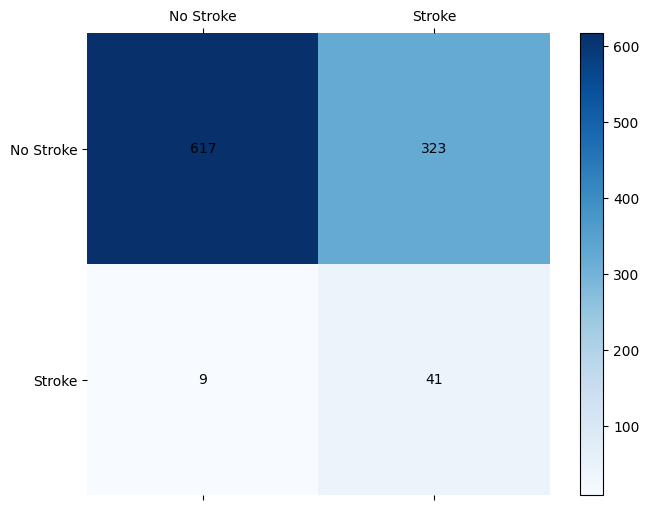

In [153]:
report_and_plot("SVM", svm_pred)


=== Logistic ===
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       940
           1       0.14      0.84      0.24        50

    accuracy                           0.73       990
   macro avg       0.56      0.78      0.54       990
weighted avg       0.95      0.73      0.81       990

Balanced Accuracy: 0.7838297872340425
F1-Weighted: 0.8080910525129593
Recall (pos): 0.84


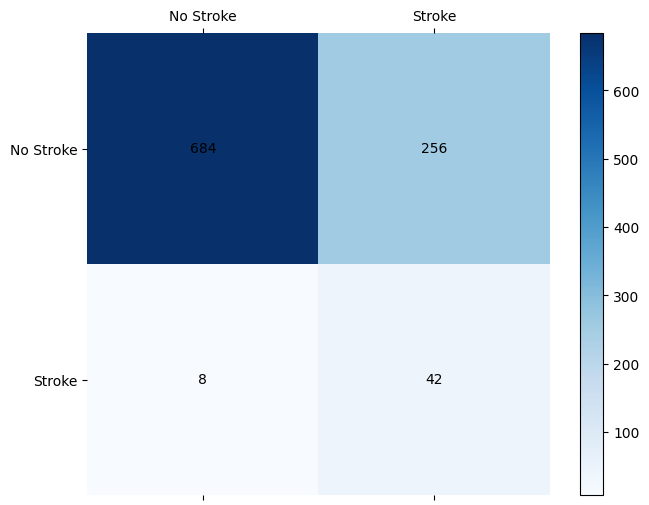

In [154]:
report_and_plot("Logistic", log_pred)

For the end result, the SVM model scored 82% for recall and the Logistic model scored 84%, beating the SVM by a small percentage. 

Out of all the stroke cases in the dataset, the Logistic Regression model was able to correctly flag **84%** of them.